# I stumbled into this small project by accident. I spent hours manually googling the ages of political candidate for an election forecasting model, and only months after its completion did i come up with the idea to use the ChatGPT API to collect this data for me. I tried it out. Here is how it did.


# i attempted to make ChatGPT my coworker, but for now ill keep it in the friend zone. 

In [60]:
import pandas as pd
import openai
from openai import OpenAI
import re
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Suppress all warnings
warnings.filterwarnings("ignore")

import plotly.express as px

# Import senate data

In [61]:
senate_results = pd.read_excel('senate_ChatGPT.xlsx')
senate_results['gpt_age'] = None

In [62]:
gpt_api_key = os.getenv('GPT_API_KEY')
client = OpenAI(
    api_key = gpt_api_key,
)

In [63]:
for index, row in senate_results.iterrows():
    # Extract contents from columns
    year = row['year']
    state = row['state']
    first_name = row['first_name']
    last_name = row['last_name']
    party = row['party']

    prompt = (f'Provide only the age of {first_name} {last_name}. They were a candidate in the {year} {state} federal senate election')

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
          {"role": "system", "content": "You are a numbers minded assistant"},
          {"role": "user", "content": prompt},
        ]
      )

    # here is the raw gpt response, it is very inconsistant so i need to extract only the age
    age = response.choices[0].message.content


    # which is done by finding the first occurrence of two consecutive digits
    match = re.search(r'\d\d', age)
    if match:
        result = match.group()
        result = int(result)
    else:
        result = 0


    correction = 2021 - row['year']
    result = result - correction

    senate_results.at[index, 'gpt_age'] = result

## I made the code work but the responses were untrustworthy. I got a lot of unsure responses and confident false positives.

## adjust the age column so that it relects the candidate's age on election year

In [64]:
# change gpt response type to an integer
senate_results['gpt_age'] = senate_results['gpt_age'].fillna(0).astype(int)

# because GPT gave the current age, i found the current year, then subtracted how many years ago the election was from the provided age.
# the knowledge cutoff for GPT-3.5 is 9/2021
senate_results['year_difference'] = 2001 - senate_results['year']
senate_results['gpt_age'] = senate_results['gpt_age'] - senate_results['year_difference']

# drop the 'year_difference' column
senate_results.drop(columns=['year_difference'], inplace=True)

# Now lets investigate how accurate chat GPT is

In [65]:
senate_results = senate_results[senate_results['gpt_age'] > 19]
senate_results['age_difference'] = (senate_results['gpt_age'] - senate_results['age']).abs()

In [66]:
senate_results

,year,state,fec_id,first_name,last_name,party,age,gpt_age,age_difference
0,2018,CT,S2CT00132,Christopher S.,Murphy,D,44,59,15
1,2016,CT,S0CT00177,Richard,Blumenthal,D,70,80,10
2,2020,ID,S6ID00104,Ray J.,Writz,O,68,69,1
3,2016,ID,S6ID00104,Ray J.,Writz,O,64,30,34
5,2018,IN,S6IN00225,Lucy M.,Brenton,L,39,92,53
...,...,...,...,...,...,...,...,...,...
270,2020,WV,S4WV00159,Shelley Moore,Capito,R,66,85,19
271,2020,WY,S0WY00137,Cynthia M.,Lummis,R,65,84,19
272,2018,WY,S8WY00189,Gary,Trauner,D,59,34,25
273,2018,WY,S6WY00068,John,Barrasso,R,65,80,15


<Figure size 800x600 with 0 Axes>

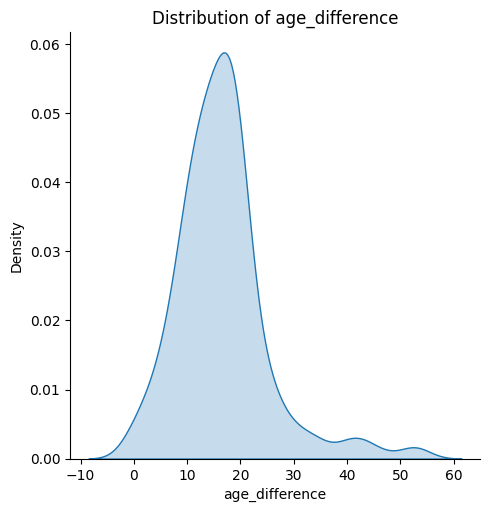

In [67]:
# Plotting the distribution
plt.figure(figsize=(8, 6))
sns.displot(data=senate_results, x=senate_results['age_difference'], kind='kde', fill=True)
plt.title(f'Distribution of age_difference')
plt.show()

In [19]:
cuts = [5, 7, 9, 11, 13]
for cut in cuts:
  senate_results['binary_column'] = (senate_results['age_difference'] > cut).astype(int)

  one = senate_results['binary_column'].value_counts()[0]
  zero = senate_results['binary_column'].value_counts()[1]

  two = one/zero

  all_merged_c = senate_results[['votes', 'vote_share', 'incumbent', 'binary_column']]

  X = all_merged_c[['votes', 'vote_share', 'incumbent']]
  y = all_merged_c['binary_column']

  # Split data into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Create and fit the logistic regression model
  model = LogisticRegression()
  model.fit(X_train, y_train)

  # Predict the target variable
  y_pred = model.predict(X_test)

  # Calculate accuracy
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy:", accuracy, "ratio", two, "cutoff", cut)

KeyError: "['votes', 'vote_share', 'incumbent'] not in index"